# Uso de UrbanPy

UrbanPy es un proyecto open source para automatizar la extracción, medición y visualización de métricas de accesibilidad urbana. La librería se basa en información abierta a partir del proyecto de [OpenStreetMap](https://www.openstreetmap.org/). OpenStreetMap (OSM) es un servicio de mapas online que publica información contribuida en forma libre por más de un millón de voluntarios, que benefician a los 5,5 millones de usuarios de la plataforma.

Los contribuidores más entusiastas mapean barrios completos utilizando herramientas GPS para enviar información local completa, actualizada y precisa a OpenStreetMap. Varias empresas y entidades públicas que producen información geográfica también contribuyen al permitir que sus datos sean incluidos. Existen equipos profesionales de contribuidores que que se coordinan para agregar y mantener actualizada información georeferenciada de límites políticos, calles, edificios, negocios y otros puntos de interés; en ocasiones empleados por compañías que dependen de OpenStreetMap para el “mapa base” de sus productos, como mapbox.com y carto.com.

Toda la información disponible en OpenStreetMap puede ser descargada y reutilizada por cualquier persona, ya sea accediendo al mapa online, obteniendo una copia completa de la base de datos, o accediendo a los datos vía API.

UrbanPy puede instalarse mediante *pip*, el "administrador de paquetes" de Python.

In [ ]:
pip install urbanpy

Una vez instalada la librería UrbanPy, es necesario reiniciar la máquina virtual para efectivizar la instalación en Google Colab. 

Para eso podemos cliquear el botón "RESTART RUNTIME" que aparece al final de la salida de la celda anterior, que luce así:


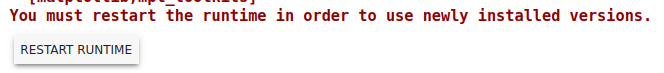

Una vez que UrbanPy se encuentra instalado y listo para usar, activamos las librerías de funciones que vamos a utilizar con el comando `import`:



In [ ]:
import sys
sys.path.append('..')
import urbanpy as up
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import plotly.express as px 

## Descarga de datos urbanos

Para descargar información, primero es necesario definir el lugar que queremos analizar. En este ejemplo, vamos a utilizar la ciudad de Buenos Aires, en Argentina. 

In [ ]:
ba = up.download.nominatim_osm('Ciudad de Buenos Aires, Argentina')

La funcion *download.nominatim_osm* nos permite obtener los límites de la ciudad. Utilizamos la función *polt* para visualizar nuestra descarga. 

<AxesSubplot:>

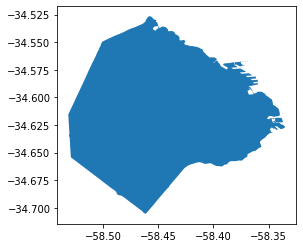

In [ ]:
ba.plot()

Para aplicar algoritmos y visualizar datos espaciales variados definimos una unidad espacial uniforme. UrbanPy permite aprovechar fácilmente todo el poder del paquete [Uber H3](https://eng.uber.com/h3/) para dividir la ciudad en hexágonos uniformes.

In [ ]:
hex_ba = up.geom.gen_hexagons(resolution= 8, city=ba)

/usr/local/lib/python3.7/dist-packages/urbanpy/geom/geom.py:168: FutureWarning:

Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.



La variable *city* requiere un objeto espacial, en este caso la geometría de la ciudad de Buenos Aires. 
La variable *resolution* permite ajustar el tamaño de las celdas hexagonales: mayor resolución implica una división del territorio en más celdas. 

<AxesSubplot:>

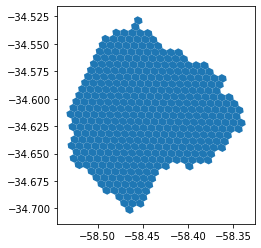

In [ ]:
hex_ba.plot()

Podemos utilizar la función *head* para ver los primeros registros. 

In [ ]:
hex_ba.head()

,hex,geometry
0,88c2e30247fffff,"POLYGON ((-58.45302 -34.56135, -58.44902 -34.5..."
1,88c2e38d21fffff,"POLYGON ((-58.50269 -34.66442, -58.49869 -34.6..."
2,88c2e31245fffff,"POLYGON ((-58.45448 -34.68792, -58.45048 -34.6..."
3,88c2e3115dfffff,"POLYGON ((-58.39352 -34.64253, -58.38953 -34.6..."
4,88c2e31117fffff,"POLYGON ((-58.39479 -34.61374, -58.39079 -34.6..."


La función *shape* nos permite ver el tamaño del dataset. 

In [ ]:
hex_ba.shape

(406, 2)

En este caso, la ciudad de Buenos Aires se dividió en 2812 celdas. 

## Descarga de datos de población

La información de datos de población se descarga a nivel país con la función *hdx_fb_population* disponible en la librería UrbanPy.
En esta función se define en primer lugar el país, y luego el tipo de población: *full* (refiere a toda la población), *children* (refiere a niños y niñas), *youth* (refiere a jóvenes) y *elderly* (refiere a la población adulta). 
La función accede a los [estimados demográficos de alta resolución que ha creado Facebook](https://dataforgood.facebook.com/dfg/docs/high-resolution-population-density-maps-demographic-estimates-documentation), con datos precisos sobre la densidad de población en cualquier parte del mundo. 

In [ ]:
pop_arg = up.download.hdx_fb_population('argentina', 'full')

Si por alguna razón la función `hdx_facebook_population()` no encuentra datos del país y tipo deseados, se puede realizar una búsqueda manual en el [repositorio online](https://data.humdata.org/organization/facebook) de los datos, y copiar el identificador de dataset.

Por ejemplo, para la población general de Ecuador, encontramos

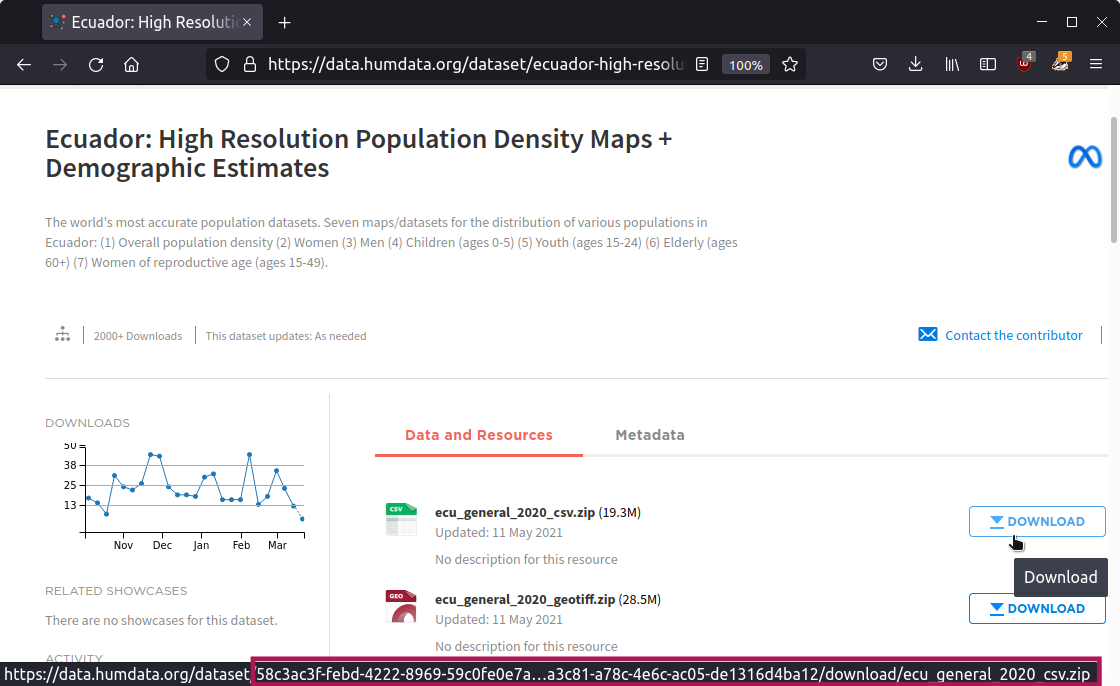

Ya provistos del identificador podemos realizar la descarga vía UrbanPy, así:

In [ ]:
pop_ecu = up.download.hdx_dataset('58c3ac3f-febd-4222-8969-59c0fe0e7a0d/resource/c05a3c81-a78c-4e6c-ac05-de1316d4ba12/download/ecu_general_2020_csv.zip')

Una vez que tenemos los datos de población, utilizamos la función head para ver los primeros registros.

In [ ]:
pop_arg.head()

,latitude,longitude,population_2015,population_2020
0,-55.057361,-66.452639,4.108063,4.570431
1,-55.056806,-66.451806,4.108063,4.570431
2,-55.056250,-66.462361,4.108063,4.570431
3,-55.052639,-66.495139,4.108063,4.570431
4,-55.052083,-66.479861,4.108063,4.570431


Como podemos observar, contamos con la población de 2015, 2020 y la latitud/longitud. Los datos corresponden a toda la Argentina. Vamos primero a filtrar por la zona de interés.

In [ ]:
pop_ba = up.geom.filter_population(pop_arg, ba)

Al aplicar la función *filter_population*, filtramos la población dentro del bounding box que contiene a nuestra ciudad. 
El bounding box (o caja de coordenadas) refiere a las coordenadas de un rectángulo que abarque la zona de interés, es decir los valores máximos y mínimos de latitud y longitud.

<AxesSubplot:>

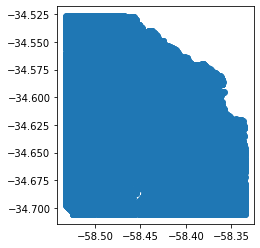

In [ ]:
pop_ba.plot()

Efectivamente, los datos se extienden por fuera del límite de nuestra ciudad. 

Ahora que tenemos los puntos de población, y los hexágonos, vamos a calcular la población por hexagono. Para eso, se utiliza la función *merge_shape_hex*

In [ ]:
hex_ba = up.geom.merge_shape_hex(hex_ba, pop_ba, agg={'population_2020':'sum'})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



<AxesSubplot:>

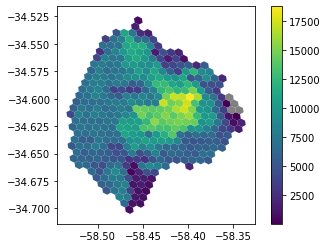

In [ ]:

hex_ba.plot('population_2020', legend=True, missing_kwds={'color':'grey'})


Vamos a armar un mapa interactivo para visualizar la información. Para eso, podemos utilizar la función *choropleth_map*. Esta función se basa en *choropleth_mapbox* de la librería *plotly*. [Aquí](https://plotly.com/python/mapbox-county-choropleth/) se pueden ver más parámetros para configurar. 

In [ ]:
fig = up.plotting.choropleth_map(hex_ba, 'population_2020', title='Población estimada - 2020', 
                                 zoom = 10, color_continuous_scale="Viridis",
                                 opacity=0.8,
                                 labels={'population_2020':'Población 2020'}
                                 
                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()

## Accesibilidad urbana


Para evaluar accesibilidad urbana, es necesario primero definir accesibilidad a que lugar(es) de interés, para luego obtener los datos de esos puntos de interés.  
Para obtener datos georeferenciados de puntos de interés realizaremos consultas a [Overpass](https://overpass-api.de/), una interfaz que permite extraer información de la base de datos global de OpenStreetMap. En [este wiki](https://https://wiki.openstreetmap.org/wiki/Map_features) se pueden consultar los datos disponibles en OSM.

Overpass requiere que se especifique un *bounding box*. Para obtenerlo, se puede usar la propiedad *total_bounds*, que devuelve un array con los valores.

In [ ]:
ba.total_bounds

array([-58.5314494, -34.705637 , -58.3351423, -34.5265535])

En este ejemplo, nos interesa evaluar la accesibilidad a establecimientos de salud. Estos servicios son esenciales para garantizar la calidad de vida de la ciudadanía. 

In [ ]:
es = up.download.overpass_pois(bounds=ba.total_bounds, facilities='health')

Nuevamente, utilizamos la función *head* para ver los primeros resultados. 

In [ ]:
es.head()

,type,id,lat,lon,tags,geometry,poi_type
0,node,440909040,-34.633092,-58.521902,"{'amenity': 'pharmacy', 'healthcare': 'pharmacy'}",POINT (-58.52190 -34.63309),pharmacy
1,node,474553860,-34.605004,-58.379509,"{'amenity': 'pharmacy', 'brand': 'Farmacity', ...",POINT (-58.37951 -34.60500),pharmacy
2,node,475032869,-34.602333,-58.379779,"{'amenity': 'pharmacy', 'brand': 'Farmacity', ...",POINT (-58.37978 -34.60233),pharmacy
3,node,477543967,-34.628847,-58.525377,"{'amenity': 'pharmacy', 'healthcare': 'pharmac...",POINT (-58.52538 -34.62885),pharmacy
4,node,479156124,-34.599440,-58.371117,"{'amenity': 'pharmacy', 'brand': 'Farmacity', ...",POINT (-58.37112 -34.59944),pharmacy


Podemos ver diferentes tipos de amenities relacionados con establecimiento de salud. Veamos cuales son. 

In [ ]:
es.poi_type.value_counts()

pharmacy    770
clinic      190
dentist     104
doctors      61
hospital     33
Name: poi_type, dtype: int64

Veamos los geometrías en un mapa. 

<AxesSubplot:>

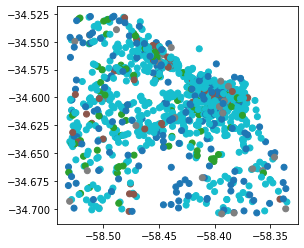

In [ ]:
es.plot('poi_type')

### Acceso a hospitales

Primero vamos a evaluar la accesibilidad a hospitales en la Ciudad Autónoma de Buenos Aires. Para eso vamos a filtrar los datos descargados por el tipo 'hospital'.

In [ ]:
hospitales = es[es['poi_type'] == 'hospital' ] 

Visualicemos solo los hospitales

<AxesSubplot:>

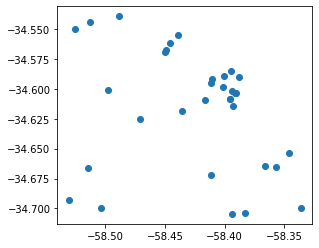

In [ ]:
hospitales.plot()

Ahora que tenemos la ubicación de los hospitales, calcularemos la distancia al hospital más cercano desde el centroide de los hexagonos. 
Primero, vamos a calcular los centroides. 

In [ ]:
hex_ba['lat'] = hex_ba.geometry.centroid.y
hex_ba['lon'] = hex_ba.geometry.centroid.x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Dentro de la librería *UrbanPy*, podemos utilizar la función *nn_search* para localizar los vecinos más cercanos (nearest neighboor).  

In [ ]:
dist_up, ind_up = up.utils.nn_search(
    tree_features=hospitales[['lat', 'lon']].values, # Puntos de interes
    query_features=hex_ba[['lat', 'lon']].values, # Centroides de los hexagonos
    metric='haversine' # Metrica de distancia
)

Agregamos la variable 'hosp_cercano' que indica el índice del hospital más cercano para ese hexágono.

In [ ]:
hex_ba['hosp_cercano'] = ind_up
hex_ba.head()

,hex,geometry,population_2020,lat,lon,hosp_cercano
0,88c2e30247fffff,"POLYGON ((-58.45302 -34.56135, -58.44902 -34.5...",10830.247529,-34.557500,-58.453768,7
1,88c2e38d21fffff,"POLYGON ((-58.50269 -34.66442, -58.49869 -34.6...",4999.083280,-34.660584,-58.503437,17
2,88c2e31245fffff,"POLYGON ((-58.45448 -34.68792, -58.45048 -34.6...",898.930099,-34.684079,-58.455230,29
3,88c2e3115dfffff,"POLYGON ((-58.39352 -34.64253, -58.38953 -34.6...",4877.262664,-34.638683,-58.394276,27
4,88c2e31117fffff,"POLYGON ((-58.39479 -34.61374, -58.39079 -34.6...",15279.337759,-34.609893,-58.395538,25


Vamos a iniciar el servidor de ruteo de OSM.   
*Esta función no se encuentra disponible en Google Colab. Para utilizarla de manera local, es necesario previamente instalar Docker.*

In [ ]:
up.routing.start_osrm_server('argentina', 'south-america', 'foot')

[
    {
        "Id": "00af1657a21ae28bc4b37e79bd050dd973370fa1a4fe2921162d3b0450b8faea",
        "Created": "2022-05-10T12:02:19.280823231Z",
        "Path": "osrm-routed",
        "Args": [
            "--algorithm",
            "mld",
            "/data/argentina-latest.osm.pbf"
        ],
        "State": {
            "Status": "exited",
            "Running": false,
            "Paused": false,
            "Restarting": false,
            "OOMKilled": false,
            "Dead": false,
            "Pid": 0,
            "ExitCode": 0,
            "Error": "",
            "StartedAt": "2022-05-10T12:46:30.894507106Z",
            "FinishedAt": "2022-05-10T13:24:16.336705549Z"
        },
        "Image": "sha256:6e654e0e06b3b580457ae3bae43474c86f10d46eeb8b1b89899e5714eff19938",
        "ResolvConfPath": "/var/lib/docker/containers/00af1657a21ae28bc4b37e79bd050dd973370fa1a4fe2921162d3b0450b8faea/resolv.conf",
        "HostnamePath": "/var/lib/docker/containers/00af1657a21ae28bc4b37e79

Aplicamos la función de ruteo a nuestro dataset

In [ ]:
distance_duration = hex_ba.apply(
    lambda row: up.routing.osrm_route(
        origin=row.geometry.centroid, 
        destination = hospitales.iloc[row['hosp_cercano']]['geometry']
    ),
    result_type='expand',
    axis=1,
)

Veamos los resultados

In [ ]:
distance_duration.head()

,0,1
0,279.8,203.2
1,733.1,529.8
2,220.5,160.6
3,257.0,185.1
4,407.4,293.4


El dataset resultante contiene 2 variables:  
0 corresponde a la distancia  
1 corresponde a la duración del recorrido  

Vamos a incorporar estas dos variables a nuestro dataset hex_ba

In [ ]:
hex_ba['distancia_a_hosp'] =  distance_duration[0] / 1000 # metros a km
hex_ba['duracion_a_hosp'] = distance_duration[1] / 60 # segundos a minutos

Guardamos el dataset

In [ ]:
#hex_ba.to_file("hex_ba_hospitales.json", driver= "GeoJSON")

Los pasos anteriores generan el dataset *hex_ba_hospitales* con datos de distancia y de duración. 
Cargamos el dataset de manera manual.

In [ ]:
hex_ba_r = gpd.read_file("hex_ba_ruteado.json")

NameError: ignored

Veamos que contienen los datos

In [ ]:
hex_ba_r.head()

,hex,population_2020,cant,r_ecpc,lat,lon,ec_cercano,distancia_a_ec,duracion_a_ec,geometry
0,89c2e311dcfffff,1251.231181,0.0,0.0000,-34.595555,-58.432631,2426,0.2798,3.386667,"POLYGON ((-58.43174 -34.59693, -58.43070 -34.5..."
1,89c2e3104a7ffff,1589.059121,0.0,0.0000,-34.642215,-58.452816,976,0.7331,8.830000,"POLYGON ((-58.45192 -34.64359, -58.45089 -34.6..."
2,89c2e317693ffff,1057.349601,1.0,0.9458,-34.605325,-58.523561,1235,0.2205,2.676667,"POLYGON ((-58.52267 -34.60670, -58.52164 -34.6..."
3,89c2e310957ffff,1049.052065,0.0,0.0000,-34.575218,-58.492682,875,0.2570,3.085000,"POLYGON ((-58.49179 -34.57660, -58.49076 -34.5..."
4,89c2e312b0bffff,1213.993986,0.0,0.0000,-34.608063,-58.497491,2197,0.4074,4.890000,"POLYGON ((-58.49660 -34.60944, -58.49556 -34.6..."


Ahora vamos a realizar un mapa interactivo que muestre la distancia de cada hexágono.

In [ ]:
fig = up.plotting.choropleth_map(hex_ba_r, 'distancia_a_hosp', title='Distancia a establecimientos de comida', 
                                 zoom = 10, color_continuous_scale="Viridis",
                                 opacity=0.8,
                                 labels={'distancia_a_hosp':'Distancia (km)'}
                                 
                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()

Veamos si la duración de los recorridos muestra los mismos patrones que las distancias

In [ ]:
fig = up.plotting.choropleth_map(hex_ba_r, 'duracion_a_hosp', title='Duración de los recorridos a establecimientos de comida', 
                                 zoom = 10, color_continuous_scale="Viridis",
                                 opacity=0.8,
                                 labels={'duracion_a_hosp':'Duracion (min)'}
                                 
                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()

### Disponibilidad de farmacias

Queremos evaluar ahora la cantidad de farmacias disponibles cada 10mil habitantes.  
Cabe destacar que OSM es un proyecto colaborativo y que los datos pueden tener sesgos en zonas donde hay poca actividad de la comunidad cargando los datos.

In [ ]:
farmacias = es[es['poi_type']== 'pharmacy']

,type,id,lat,lon,tags,geometry,poi_type
0,node,440909040,-34.633092,-58.521902,"{'amenity': 'pharmacy', 'healthcare': 'pharmacy'}",POINT (-58.52190 -34.63309),pharmacy
1,node,474553860,-34.605004,-58.379509,"{'amenity': 'pharmacy', 'brand': 'Farmacity', ...",POINT (-58.37951 -34.60500),pharmacy
2,node,475032869,-34.602333,-58.379779,"{'amenity': 'pharmacy', 'brand': 'Farmacity', ...",POINT (-58.37978 -34.60233),pharmacy
3,node,477543967,-34.628847,-58.525377,"{'amenity': 'pharmacy', 'healthcare': 'pharmac...",POINT (-58.52538 -34.62885),pharmacy
4,node,479156124,-34.599440,-58.371117,"{'amenity': 'pharmacy', 'brand': 'Farmacity', ...",POINT (-58.37112 -34.59944),pharmacy


Vamos a evaluar disponibilidad de comercios per capita dentro de nuestros polígonos hexagonales. Para eso, vamos a calcular la cantidad de comercios en cada hexagono. 
Incorporamos la variable *cant* para indicar la cantidad de comercios.

In [ ]:
farmacias['cantidad'] = 1

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Calculamos la cantidad de comercios por hexágono

In [ ]:
hex_ba_farmacias = up.geom.merge_shape_hex(hex_ba, farmacias, agg={'cantidad':'sum'})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

/usr/local/lib/python3.7/dist-packages/urbanpy/geom/geom.py:234: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




Graficamos

<AxesSubplot:>

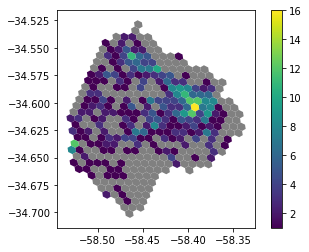

In [ ]:
hex_ba_farmacias.plot('cantidad', legend=True, missing_kwds={'color':'grey'})


Remplazamos los valores nulos por 0: en esa celda no se encontraron farmacias. 

In [ ]:
hex_ba_farmacias['cantidad'] = hex_ba_farmacias['cantidad'].fillna(0)

Vamos a generar un indicador de ratio de farmacias per capita cada 10.000 habitantes (considerando la población de 2020)

In [ ]:
hex_ba_farmacias['r_farmacia'] = round(hex_ba_farmacias['cantidad'] *10000 / hex_ba_farmacias['population_2020'], 4)

In [ ]:
hex_ba_farmacias.head()

,hex,geometry,population_2020,cantidad,r_farmacia
0,88c2e30247fffff,"POLYGON ((-58.45302 -34.56135, -58.44902 -34.5...",10830.247529,6.0,5.5400
1,88c2e38d21fffff,"POLYGON ((-58.50269 -34.66442, -58.49869 -34.6...",4999.083280,0.0,0.0000
2,88c2e31245fffff,"POLYGON ((-58.45448 -34.68792, -58.45048 -34.6...",898.930099,0.0,0.0000
3,88c2e3115dfffff,"POLYGON ((-58.39352 -34.64253, -58.38953 -34.6...",4877.262664,0.0,0.0000
4,88c2e31117fffff,"POLYGON ((-58.39479 -34.61374, -58.39079 -34.6...",15279.337759,12.0,7.8537


Graficamos

<AxesSubplot:>

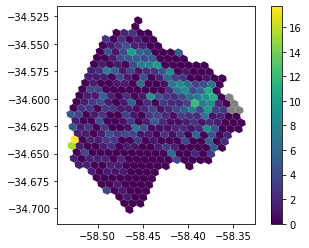

In [ ]:
hex_ba_farmacias.plot('r_farmacia', legend=True, missing_kwds={'color':'grey'})

Mapa interactivo

In [ ]:
fig = up.plotting.choropleth_map(hex_ba_farmacias, 'r_farmacia', title='Ratio de Farmacias', 
                                 zoom = 10, color_continuous_scale="Viridis",
                                 opacity=0.8,
                                 labels={'r_farmacia':'Farmacias c/10000hab'}
                                 
                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()

Si bien hay zonas donde el indicador bajo corresponde a vacíos urbanos, es posible que la zona sur de la ciudad no se encuentren todas las farmacias que existen en OSM.